In [0]:
%mkdir save_model
%mkdir save_graph

파이썬과 케라스로 배우는 강화학습 [코드](https://github.com/rlcode/reinforcement-learning-kr-v2)를 참고하였습니다. 

### 1. 라이브러리 임폴트 

In [0]:
import os
import sys
import gym
import pylab
import random
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import deque
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform


### 2. DQN 모델 정의 

In [0]:
# 상태가 입력, 큐함수가 출력인 인공신경망 생성
class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size,
                            kernel_initializer=RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q


# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.optimizer = Adam(lr=self.learning_rate)

        # 타깃 모델 초기화
        self.update_target_model()

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model(state)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        # 학습 파라메터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            # 현재 상태에 대한 모델의 큐함수
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            # 다음 상태에 대한 타깃 모델의 큐함수
            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)

            # 벨만 최적 방정식을 이용한 업데이트 타깃
            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))

        # 오류함수를 줄이는 방향으로 모델 업데이트
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))

    def test_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        # 학습 파라메터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            # 현재 상태에 대한 모델의 큐함수
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            # 다음 상태에 대한 타깃 모델의 큐함수
            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)

            # 벨만 최적 방정식을 이용한 업데이트 타깃
            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))

        return loss




### 3. DQN 모델 학습

In [0]:
if __name__ == "__main__":
    # CartPole-v1 환경, 최대 타임스텝 수가 500
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # DQN 에이전트 생성
    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []
    score_avg = 0

    num_episode = 300
    for e in range(num_episode):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            # 타임스텝마다 보상 0.1, 에피소드가 중간에 끝나면 -1 보상
            score += reward
            reward = 0.1 if not done or score == 500 else -1

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 매 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            state = next_state

            if done:
                # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()
                # 에피소드마다 학습 결과 출력
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("episode: {:3d} | score avg: {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(
                      e, score_avg, len(agent.memory), agent.epsilon))

                # 에피소드마다 학습 결과 그래프로 저장
                scores.append(score_avg)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.xlabel("episode")
                pylab.ylabel("average score")
                pylab.savefig("./save_graph/graph.png")

                # 이동 평균이 400 이상일 때 종료
                if score_avg > 400:
                    agent.model.save_weights("./save_model/model", save_format="tf")
                    sys.exit()

### 4. LossSurface

In [0]:
def loss_surface(agent, alpha, beta):
         
    np.random.seed(0)
    ## 1. Checkpoint 에 훈련을 마친 Weights 를 모델에 로드하기 
    checkpoint_path = "./save_model/model"
    agent.model.load_weights(checkpoint_path)

    ## 2. 0~5 개의 가중치를 불러옴. 
    w0 = agent.model.get_weights()[0] + alpha * np.random.randn(agent.model.get_weights()[0].shape[0], agent.model.get_weights()[0].shape[1]) + beta * np.random.randn(agent.model.get_weights()[0].shape[0],agent.model.get_weights()[0].shape[1])
    w1 = agent.model.get_weights()[1] +  alpha * np.random.randn(agent.model.get_weights()[1].shape[0],)
    w2 = agent.model.get_weights()[2] + alpha * np.random.randn(agent.model.get_weights()[2].shape[0], agent.model.get_weights()[2].shape[1]) + beta * np.random.randn(agent.model.get_weights()[2].shape[0],agent.model.get_weights()[2].shape[1])
    w3 = agent.model.get_weights()[3] +  alpha * np.random.randn(agent.model.get_weights()[3].shape[0],)
    w4 = agent.model.get_weights()[4] + alpha * np.random.randn(agent.model.get_weights()[4].shape[0], agent.model.get_weights()[4].shape[1]) + beta * np.random.randn(agent.model.get_weights()[4].shape[0],agent.model.get_weights()[4].shape[1])
    w5 = agent.model.get_weights()[5] +  alpha * np.random.randn(agent.model.get_weights()[5].shape[0],) + beta * np.random.randn(agent.model.get_weights()[5].shape[0],)

    agent.model.set_weights([w0,w1,w2,w3,w4,w5])
        
    return agent.test_model().numpy() # Loss 를 반환함.

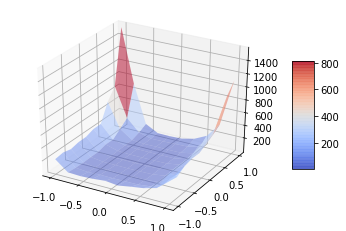

In [0]:
ms = np.linspace(-1.0, 1.0, 10)
bs = np.linspace(-1.0, 1.0, 10)

M, B = np.meshgrid(ms, bs)

zs = np.array([loss_surface(agent, alpha, beta) for alpha, beta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(M, B, Z, rstride=1, cstride=1, cmap=cm.coolwarm, alpha=0.5)

# ax.set_xlabel('m')
# ax.set_ylabel('b')
# ax.set_zlabel('error')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()